In this notebook, we propose a demonstartion of co-expression analysis in omicverse. We apply our implementation as well as the original code on the bulk data of Alzheimer's disease.

# Weight Gene Co-expression analysis

## Setting up data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import omicverse as ov
print('omicverse(Ver)',ov.__version__)
import matplotlib.pyplot as plt
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.2, Tutorials: https://omicverse.readthedocs.io/
omicverse(Ver) 1.6.2


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from scipy import stats
import networkx as nx
import datetime
import seaborn as sns
from scipy.cluster import hierarchy   
from sklearn import decomposition as skldec 
from matplotlib.colors import LinearSegmentedColormap
import scanpy as sc
from typing import Union,Tuple
import matplotlib


from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage,dendrogram

In [3]:
bulk_adata=sc.read('bulk_adata_ad.h5ad')
bulk_adata

AnnData object with n_obs × n_vars = 90 × 16504
    obs: 'Unnamed: 0', 'RNAIsolation.Group', 'Dissection.Group', 'Sample.ID', 'Case.Year', 'Case.Num', 'Region', 'Neuropath.Dx.1', 'Neuropath.Dx.2', 'Age', 'Sex', 'PMI', 'APoE', 'Clinical.Syndrome', 'Tangle.Stage', 'Plaque.Stage', 'Diagnosis', 'Plaques.Tangles', 'Braak...Braak.Stage', 'Dissection.By', 'RNA.Isolation.By', 'RIN', 'Library.Group', 'Sequencing.Group', 'TOTAL_READS', 'PF_READS', 'PF_READS_ALIGNED', 'PCT_PF_READS_ALIGNED', 'PF_ALIGNED_BASES', 'PF_HQ_ALIGNED_READS', 'PF_HQ_ALIGNED_BASES', 'PF_HQ_ALIGNED_Q20_BASES', 'PF_MISMATCH_RATE', 'PF_HQ_ERROR_RATE', 'PF_INDEL_RATE', 'READS_ALIGNED_IN_PAIRS', 'STRAND_BALANCE', 'PCT_CHIMERAS', 'PCT_ADAPTER', 'UNPAIRED_READS_EXAMINED', 'UNMAPPED_READS', 'READ_PAIR_DUPLICATES', 'READ_PAIR_OPTICAL_DUPLICATES', 'PERCENT_DUPLICATION', 'ESTIMATED_LIBRARY_SIZE', 'PF_BASES', 'PF_ALIGNED_BASES.1', 'RIBOSOMAL_BASES', 'CODING_BASES', 'UTR_BASES', 'INTRONIC_BASES', 'INTERGENIC_BASES', 'CORRECT_STRAND_REA

In [4]:
bulk_adata.obs['Neuropath.Dx.1'].value_counts()

Alzheimer's disease               44
Normal (Mild Braak Changes)       34
Normal - No Pathology Detected     8
Normal (Mild Vascular Changes)     4
Name: Neuropath.Dx.1, dtype: int64

In [5]:
bulk_adata1=bulk_adata[bulk_adata.obs['Neuropath.Dx.1'].isin(["Alzheimer's disease","Normal - No Pathology Detected"])]

In [6]:
sc.tl.pca(bulk_adata1, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [7]:
Type_color_dict={"Alzheimer's disease":'#F08888',"Normal - No Pathology Detected":'#CFDEFE'}

In [8]:
list(Type_color_dict.values())

['#F08888', '#CFDEFE']

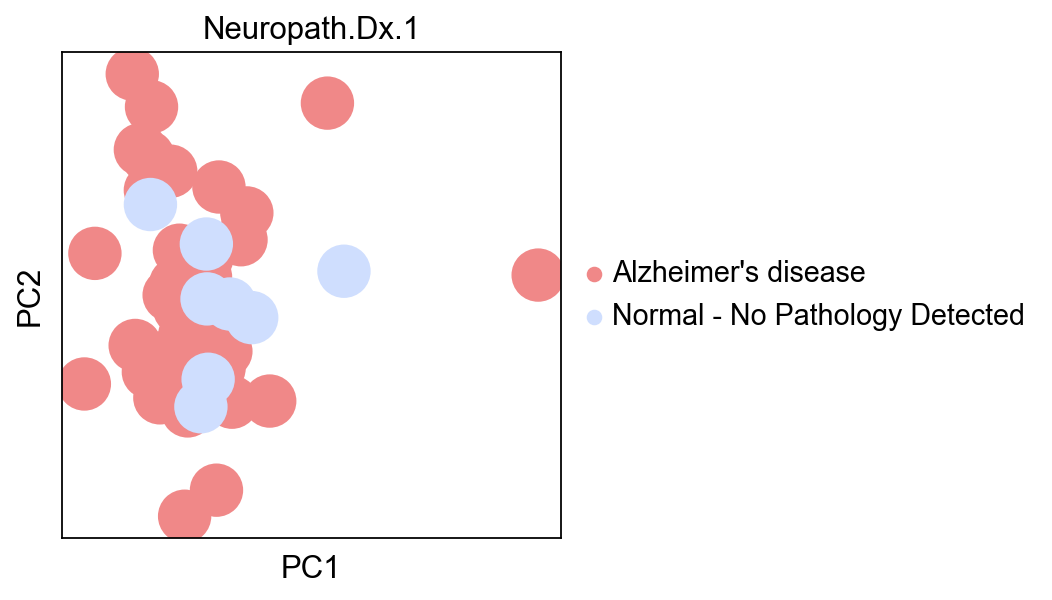

In [9]:
sc.pl.pca(bulk_adata1, color=['Neuropath.Dx.1'],show=False,palette=list(Type_color_dict.values()))
plt.savefig("figures/deg_pca.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/deg_pca.pdf",dpi=300,bbox_inches = 'tight')

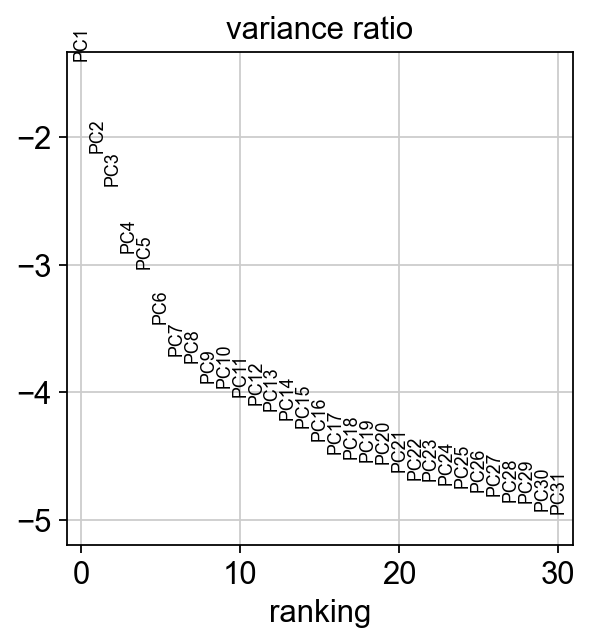

In [10]:
sc.pl.pca_variance_ratio(bulk_adata1, log=True)

In [11]:
sc.pp.neighbors(bulk_adata, n_neighbors=10, n_pcs=40)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=40
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


In [12]:
data=bulk_adata.T.to_df()

In [13]:
data.head()

Sample-1  Sample-10  Sample-100  Sample-101  Sample-11  Sample-12  \
symbol                                                                       
CELF3    5.411992   5.372127    5.918649    6.533444   5.701608   5.707154   
FCRL5    7.547789   7.615529    7.766842    7.622182   7.623010   7.460036   
SETP11   5.889153   5.115322    4.894407    5.754578   5.770548   5.400205   
ATP8B2   8.669230   7.934054    8.232009    8.193802   8.276058   8.466156   
NECTIN2  8.109728   7.792938    8.040775    7.943382   8.304275   8.599941   

         Sample-13  Sample-14  Sample-16  Sample-17  ...  Sample-89  \
symbol                                               ...              
CELF3     6.424472   6.555146   6.126113   6.940997  ...   5.634366   
FCRL5     7.553843   7.342730   7.310592   7.635867  ...   7.390826   
SETP11    5.892261   5.409041   5.540659   5.976911  ...   4.897572   
ATP8B2    8.377337   8.226151   7.897574   8.919280  ...   7.910346   
NECTIN2   8.523495   7.900356   7.760688   8.762688  ...   8.399589   

         Sample-90  Sample-91  Sample-92  Sample-93  Sample-94  Sample-95  \
symbol                                                                      
CELF3     6.583671   5.788903   6.126700   6.589674   6.446354   6.130510   
FCRL5     8.098926   7.313549   7.729042   8.356948   7.326740   7.627201   
SETP11    5.088561   5.054412   5.981792   5.487043   5.619745   5.443136   
ATP8B2    8.488744   7.982265   8.152369   8.640233   8.281754   8.195569   
NECTIN2   8.340689   8.203156   7.808631   7.486781   7.568620   7.827593   

         Sample-97  Sample-98  Sample-99  
symbol                                    
CELF3     4.964971   6.207335   5.715709  
FCRL5     7.177275   7.831815   7.543531  
SETP11    3.290396   6.425835   5.221976  
ATP8B2    7.644456   8.232993   8.382407  
NECTIN2   7.655904   8.766994   7.659839  

[5 rows x 90 columns]

## WGCNA module construct

In [14]:
from statsmodels import robust #import package
gene_mad=data.T.apply(robust.mad) #use function to calculate MAD

In [15]:
data=data.loc[gene_mad.sort_values(ascending=False).index[:5000]]

...correlation coefficient matrix is being calculated
...indirect correlation matrix is being calculated
...soft_threshold is being calculated
...appropriate soft_thresholds: 3
...distance have being calculated
...geneTree have being calculated
...dynamicMods have being calculated
..cutHeight not given, setting it to 712.005575389445  ===>  99% of the (truncated) height range in dendro.
..done.
...total: 12


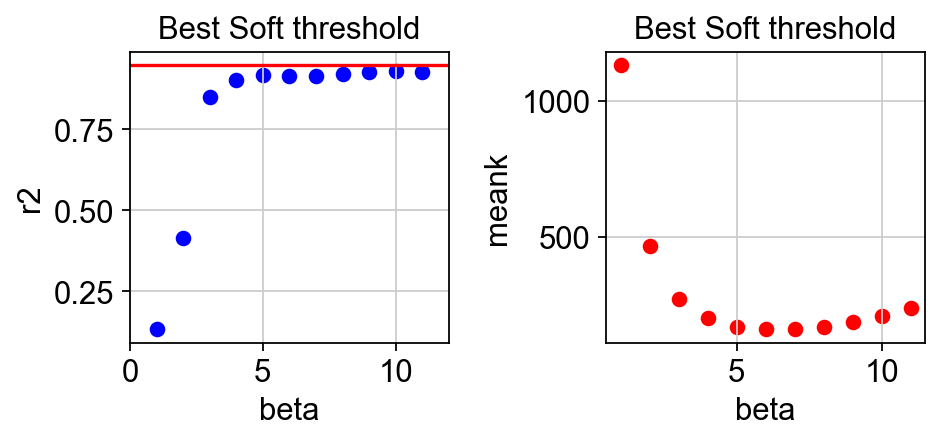

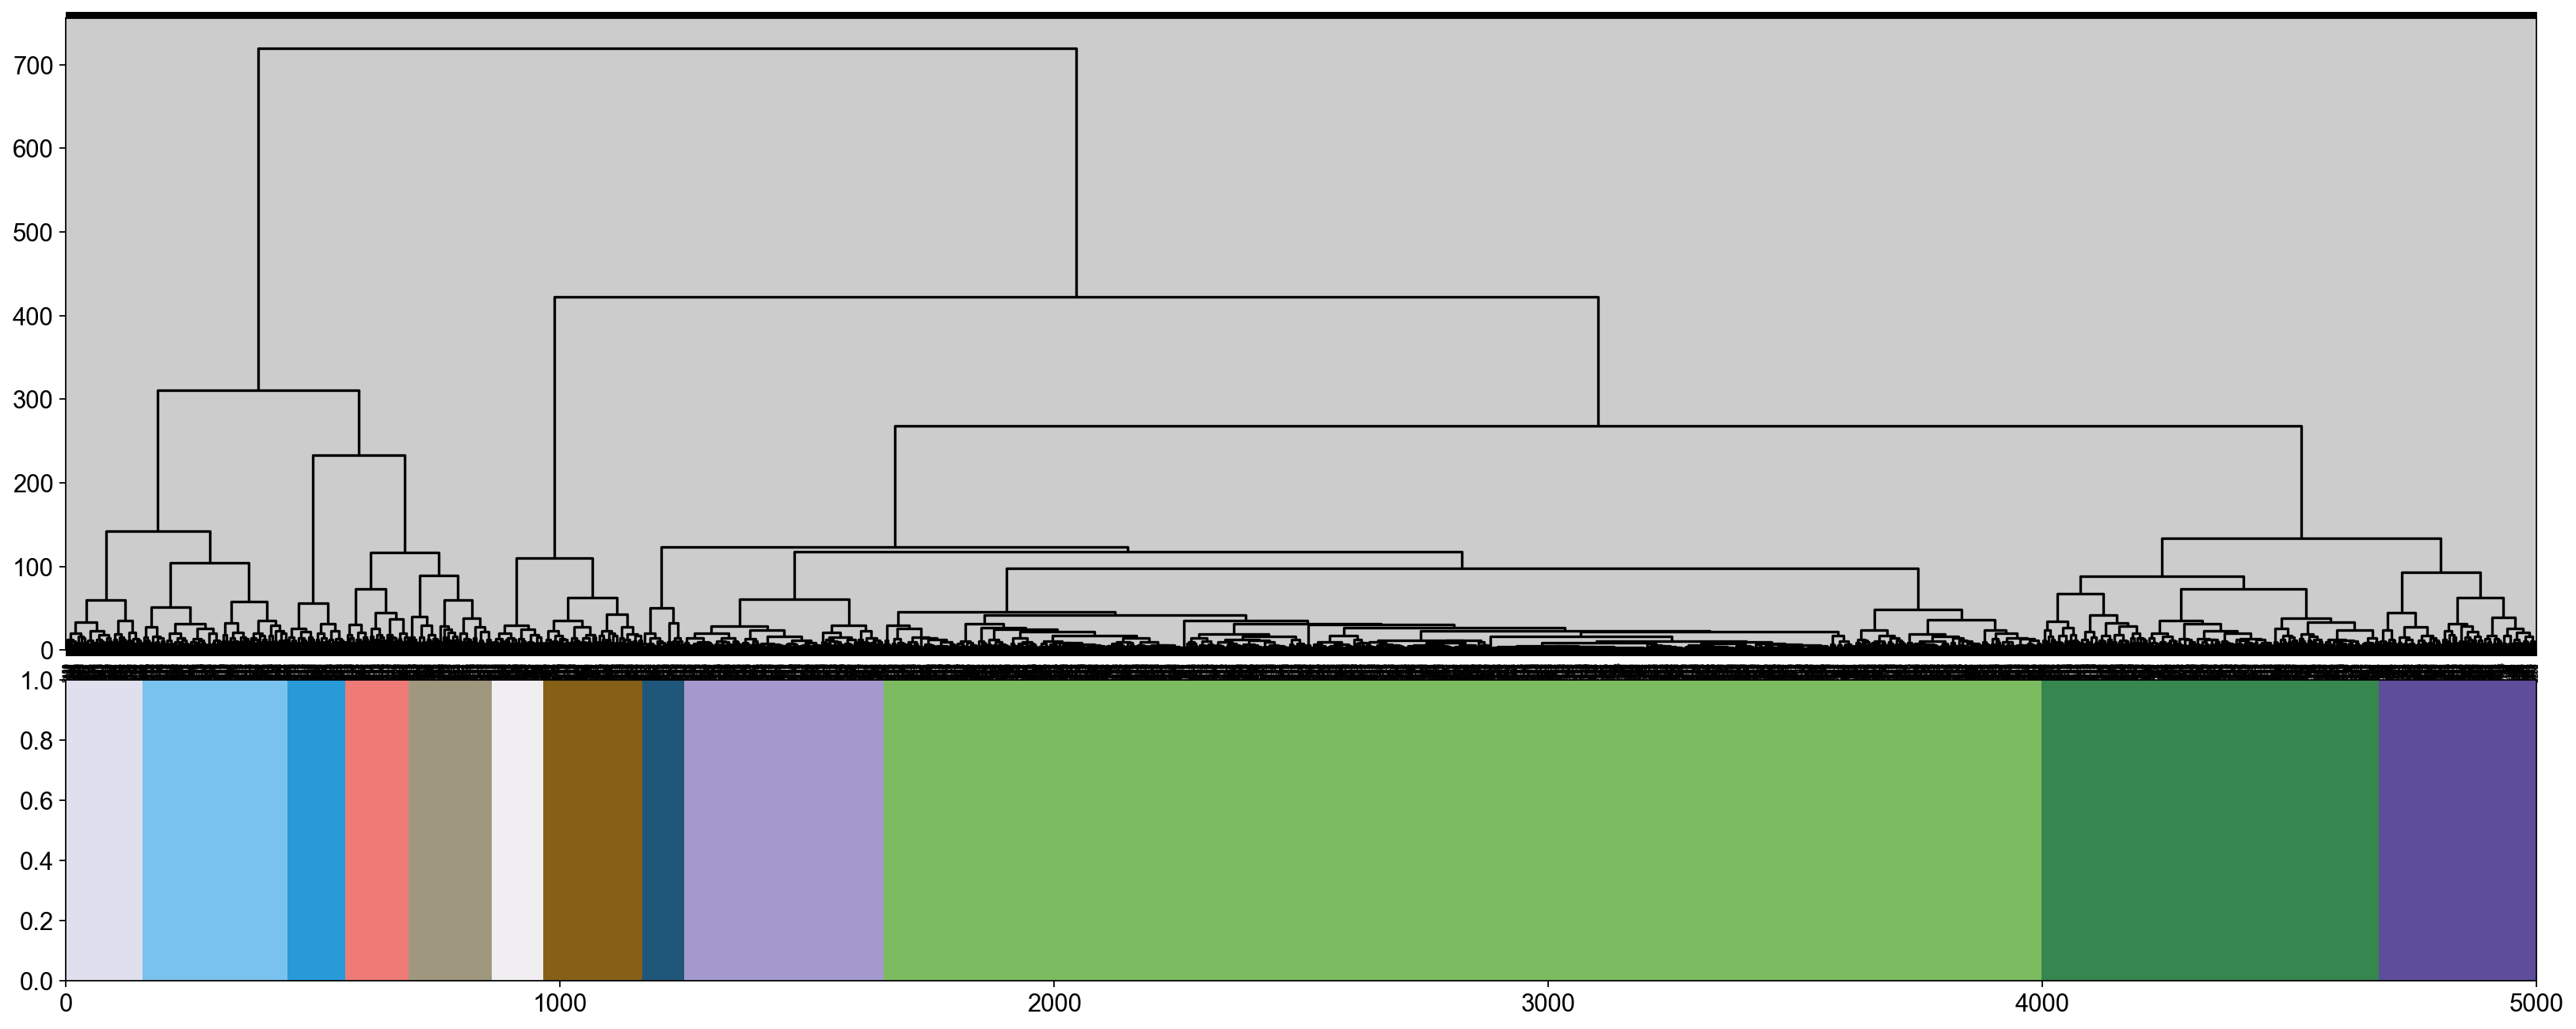

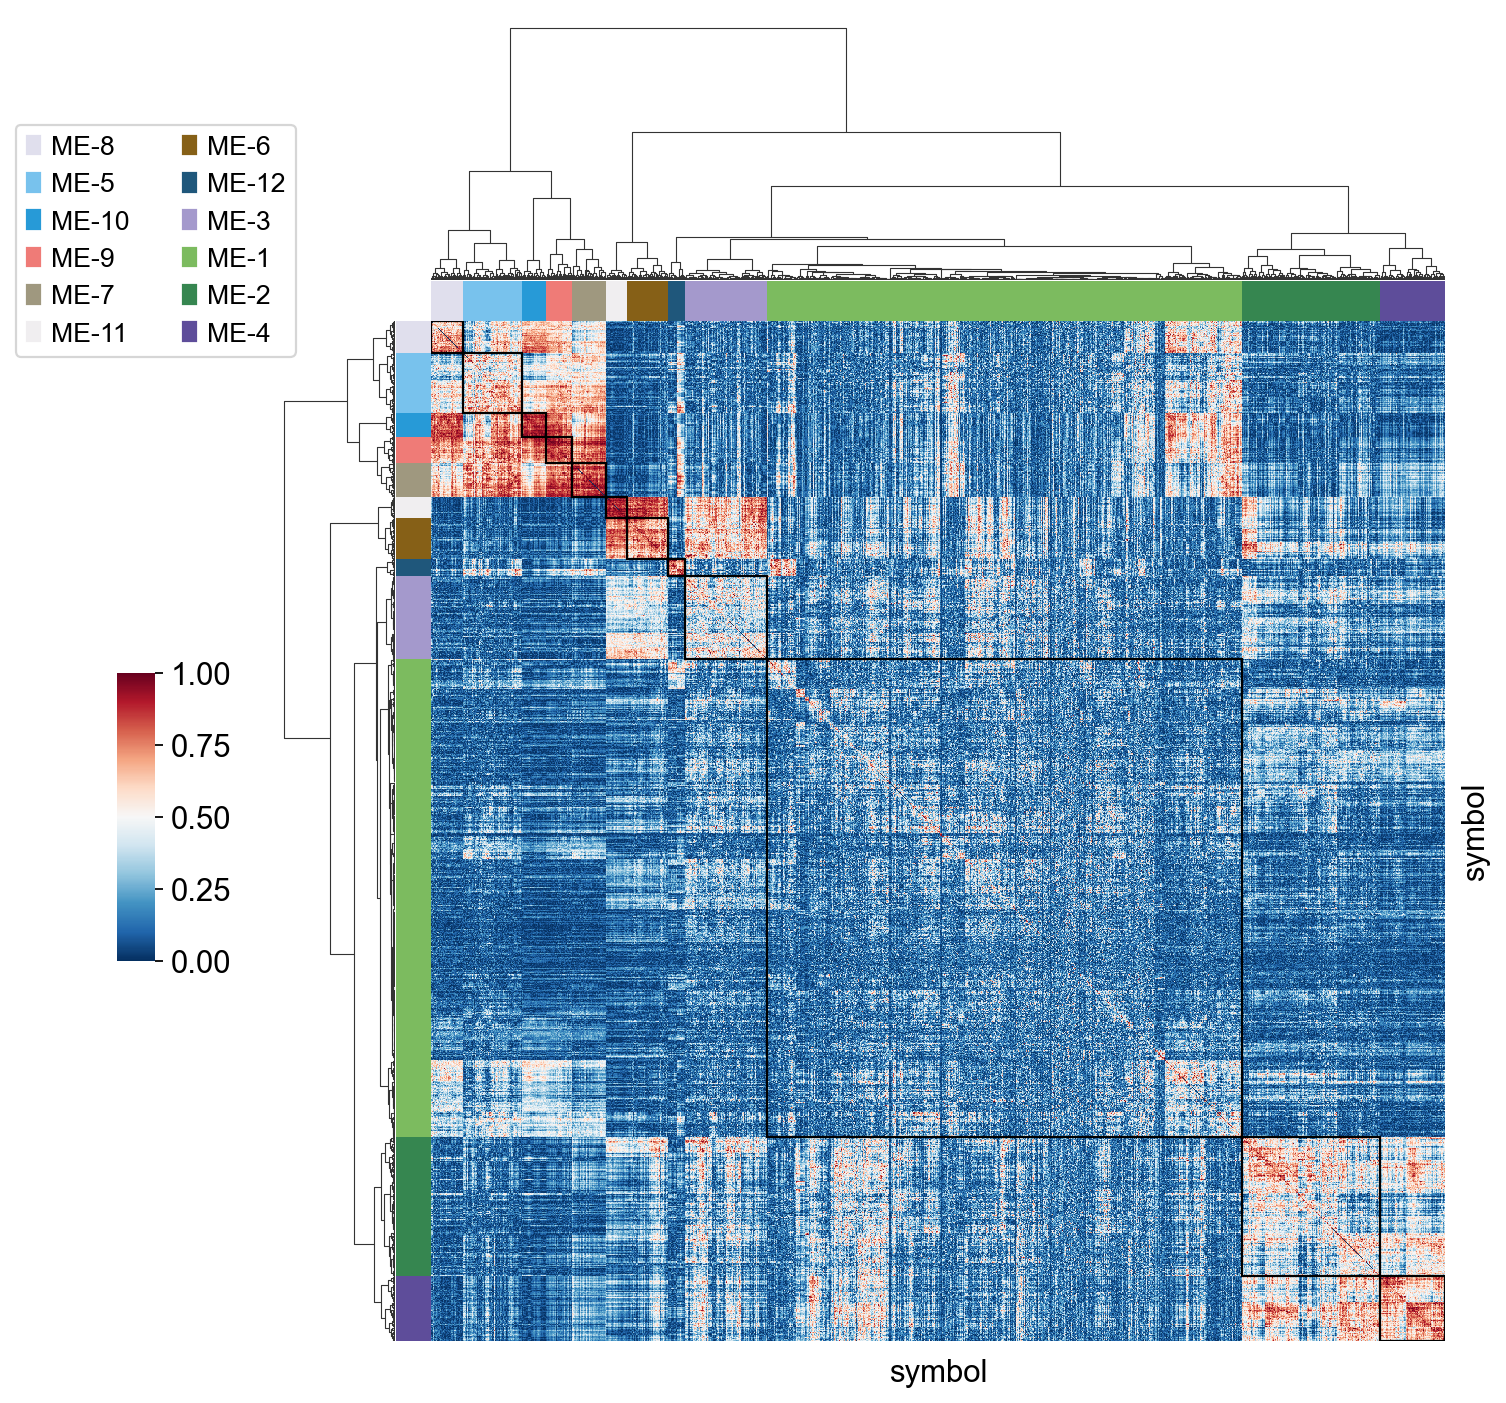

In [16]:
gene_wgcna=ov.bulk.pyWGCNA(data,save_path='result')
gene_wgcna.calculate_correlation_direct(method='pearson',save=False)
gene_wgcna.calculate_correlation_indirect(save=False)
gene_wgcna.calculate_soft_threshold(save=True)
gene_wgcna.calculate_corr_matrix()
gene_wgcna.calculate_distance()
gene_wgcna.calculate_geneTree()
gene_wgcna.calculate_dynamicMods()
module=gene_wgcna.calculate_gene_module()
gene_wgcna.plot_matrix()

In [ ]:
gene_wgcna=ov.bulk.pyWGCNA(data,save_path='result')
gene_wgcna.calculate_correlation_direct(method='pearson',save=False)

In [ ]:
gene_wgcna.calculate_correlation_indirect(save=False)

...appropriate soft_thresholds: 3


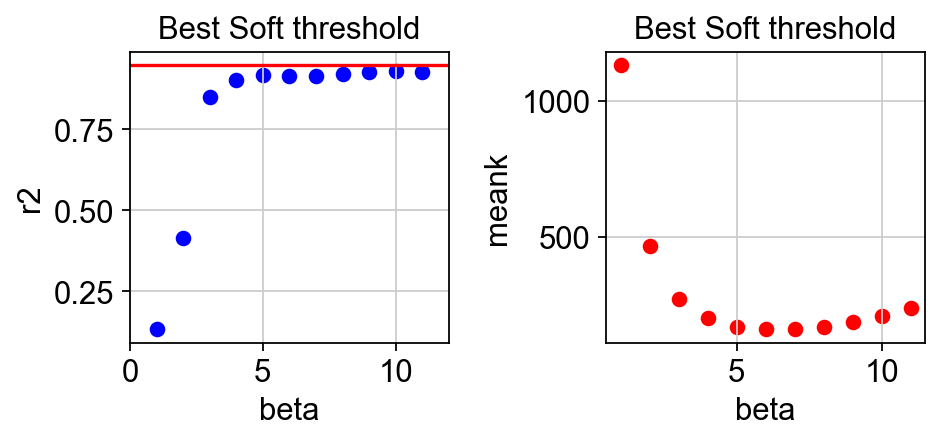

In [26]:
soft=6
threshold_range=12
re1=pd.DataFrame(columns=['beta','r2','meank'])
for j in range(1,threshold_range):
    #print('Now is:',j)
    result_i=np.float_power(gene_wgcna.temp,j)
    tt_0=np.sum(abs(result_i),axis=0)-1
    n=np.histogram(tt_0), #
    x=n[0][0]
    y=[]
    for i in range(len(n[0][1])-1):
        y.append((n[0][1][i]+n[0][1][i+1])/2)
    x=np.log10(x)
    y=np.log10(y)
    res=stats.linregress(x, y)
    r2=np.float_power(res.rvalue,2)
    k=tt_0.mean()
    re1.loc[j]={'beta':j,'r2':r2,'meank':k}
for i in re1['r2']:
    if i>0.85:
        soft=re1[re1['r2']==i]['beta'].iloc[0]
        break
print('...appropriate soft_thresholds:',soft)
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].scatter(re1['beta'],re1['r2'],c='b')
ax[0].plot([0,threshold_range],[0.95,0.95],c='r')
ax[0].set_xlim(0,threshold_range)
ax[0].set_ylabel('r2',fontsize=14)
ax[0].set_xlabel('beta',fontsize=14)
ax[0].set_title('Best Soft threshold')

ax[1].scatter(re1['beta'],re1['meank'],c='r')
ax[1].set_ylabel('meank',fontsize=14)
ax[1].set_xlabel('beta',fontsize=14)
ax[1].set_title('Best Soft threshold')
fig.tight_layout()

plt.savefig("figures/wgcna_argument.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/wgcna_argument.pdf",dpi=300,bbox_inches = 'tight')

...soft_threshold is being calculated
...appropriate soft_thresholds: 3


beta        r2        meank
1      1  0.132405  1133.533049
2      2  0.414730   466.093728
3      3  0.850136   271.719351
4      4  0.904311   198.984213
5      5  0.919662   169.249164
6      6  0.914117   158.975309
7      7  0.913955   159.795371
8      8  0.922465   168.551548
9      9  0.927906   184.260043
10    10  0.931914   207.062219
11    11  0.927202   237.852697

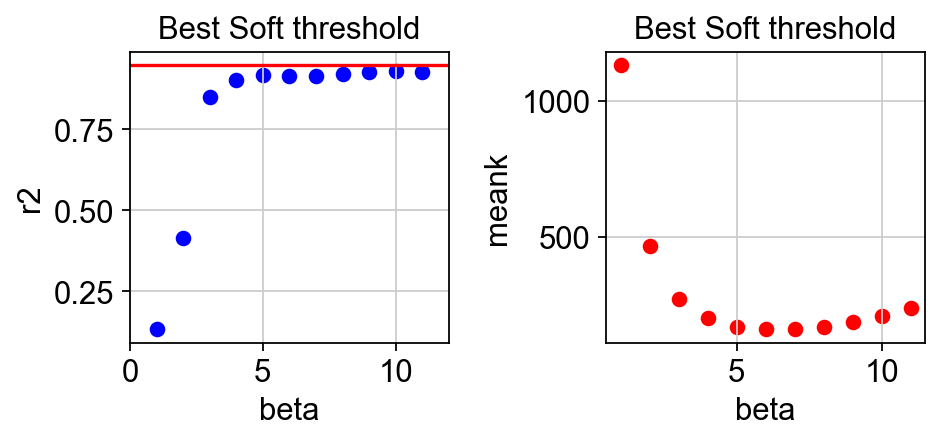

In [27]:
gene_wgcna.calculate_soft_threshold(save=True)

In [28]:
gene_wgcna.calculate_corr_matrix()

In [29]:
gene_wgcna.calculate_distance()
gene_wgcna.calculate_geneTree()
gene_wgcna.calculate_dynamicMods()


...distance have being calculated
...geneTree have being calculated
...dynamicMods have being calculated
..cutHeight not given, setting it to 712.005575389445  ===>  99% of the (truncated) height range in dendro.
..done.
...total: 12


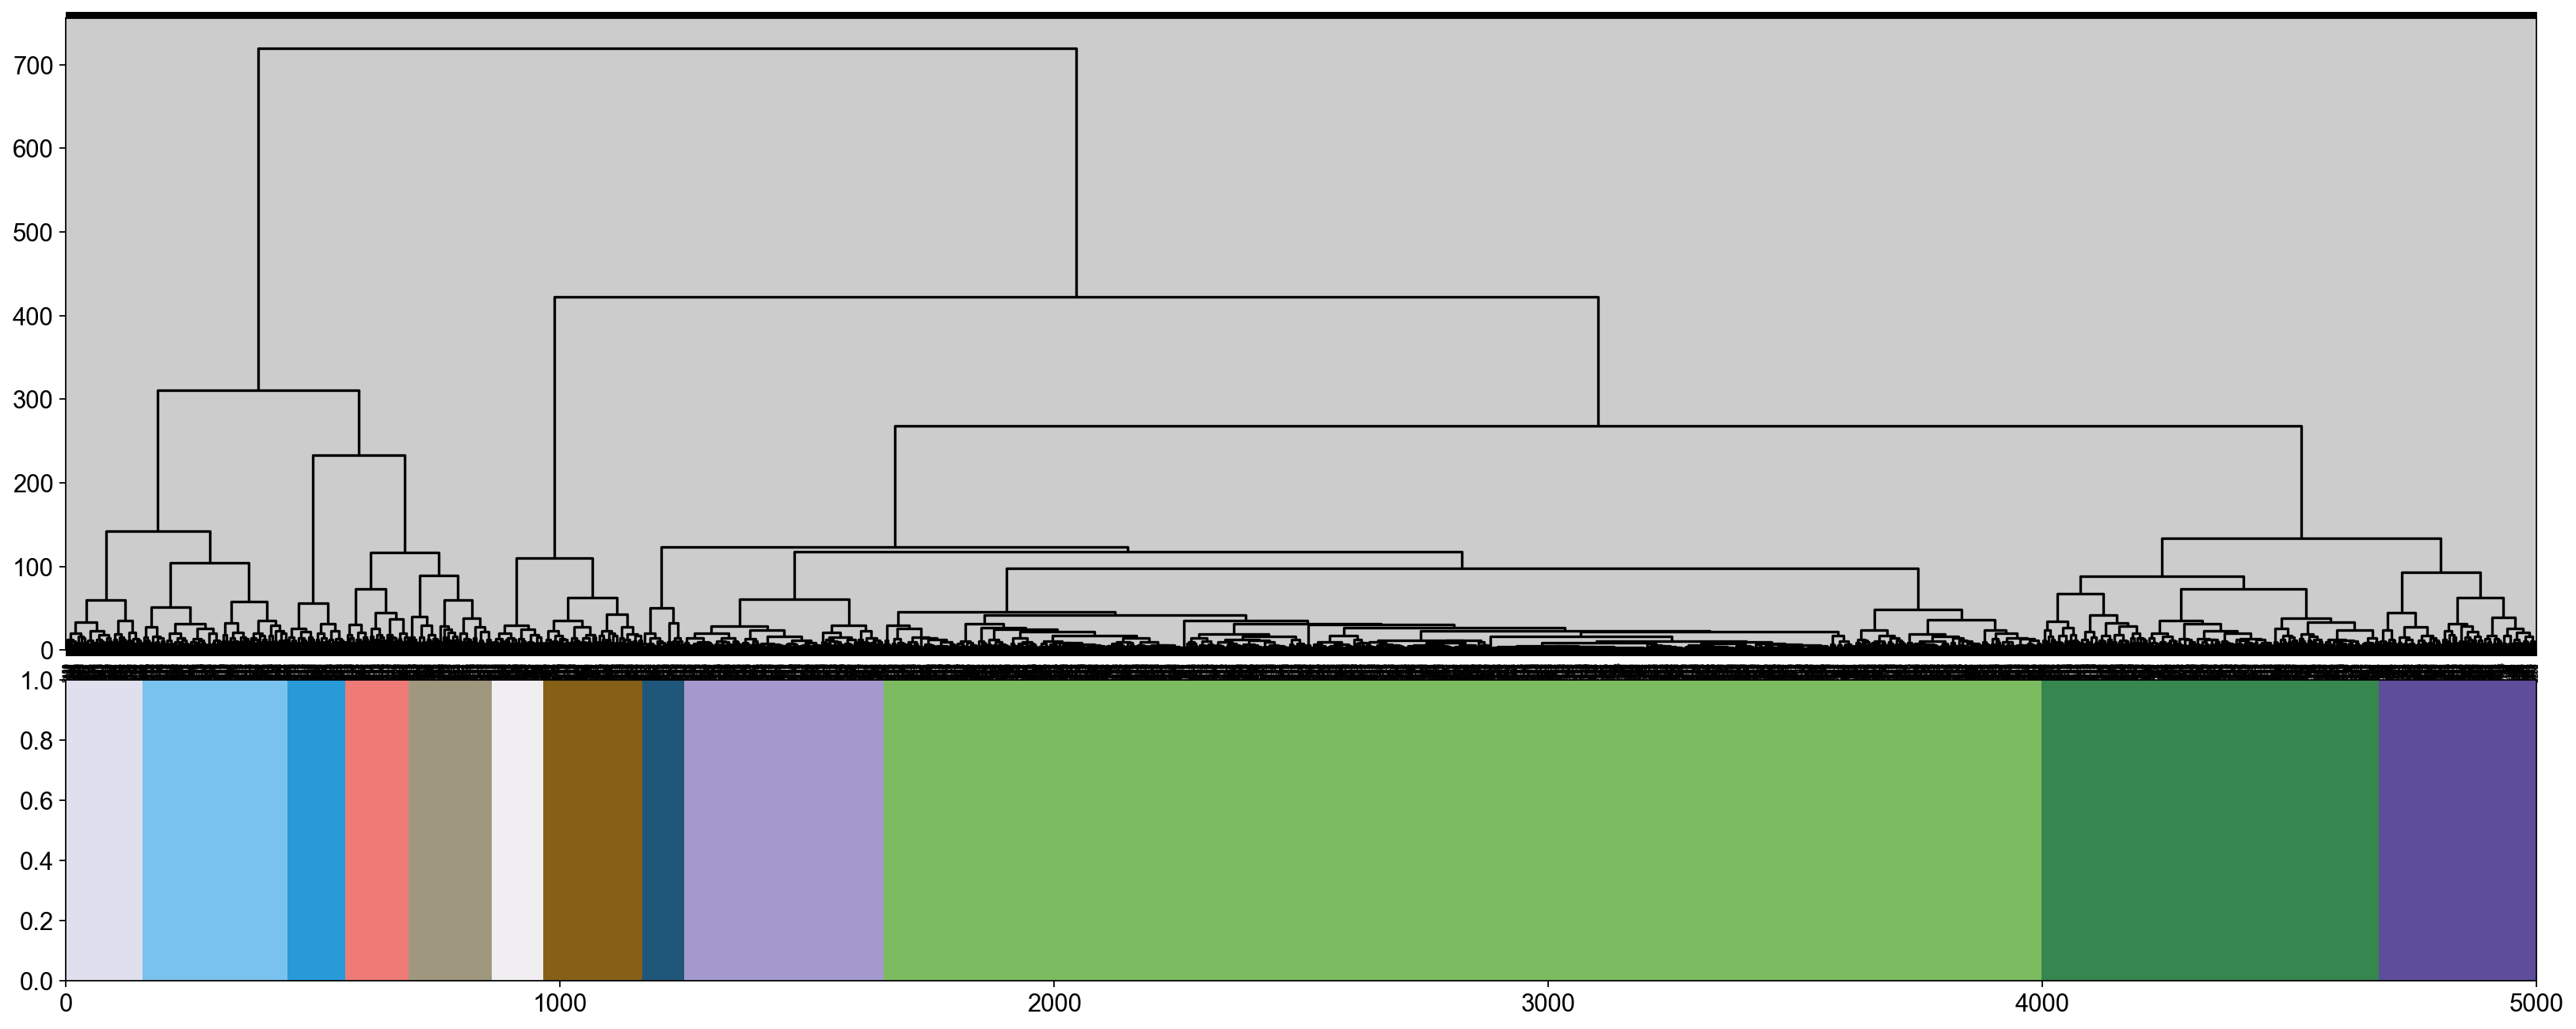

In [30]:
module=gene_wgcna.calculate_gene_module()

In [31]:
module.head()

ivl  module     name    color
0  2158       8  CACNA1H  #E0DFED
1  4429       8   NUDT14  #E0DFED
2  3533       8    CBARP  #E0DFED
3  4186       8  TAMALIN  #E0DFED
4  4834       8    CCND2  #E0DFED

In [32]:
gene_wgcna.mol.index=range(len(gene_wgcna.mol))

In [ ]:
gene_wgcna.plot_matrix()
plt.savefig('figures/module_matrix.png',dpi=300,bbox_inches = 'tight')
plt.savefig('pdf/module_matrix.pdf',dpi=300,bbox_inches = 'tight')

In [18]:
adata=bulk_adata[:,gene_mad.sort_values(ascending=False).index[:5000]]
adata

View of AnnData object with n_obs × n_vars = 90 × 5000
    obs: 'Unnamed: 0', 'RNAIsolation.Group', 'Dissection.Group', 'Sample.ID', 'Case.Year', 'Case.Num', 'Region', 'Neuropath.Dx.1', 'Neuropath.Dx.2', 'Age', 'Sex', 'PMI', 'APoE', 'Clinical.Syndrome', 'Tangle.Stage', 'Plaque.Stage', 'Diagnosis', 'Plaques.Tangles', 'Braak...Braak.Stage', 'Dissection.By', 'RNA.Isolation.By', 'RIN', 'Library.Group', 'Sequencing.Group', 'TOTAL_READS', 'PF_READS', 'PF_READS_ALIGNED', 'PCT_PF_READS_ALIGNED', 'PF_ALIGNED_BASES', 'PF_HQ_ALIGNED_READS', 'PF_HQ_ALIGNED_BASES', 'PF_HQ_ALIGNED_Q20_BASES', 'PF_MISMATCH_RATE', 'PF_HQ_ERROR_RATE', 'PF_INDEL_RATE', 'READS_ALIGNED_IN_PAIRS', 'STRAND_BALANCE', 'PCT_CHIMERAS', 'PCT_ADAPTER', 'UNPAIRED_READS_EXAMINED', 'UNMAPPED_READS', 'READ_PAIR_DUPLICATES', 'READ_PAIR_OPTICAL_DUPLICATES', 'PERCENT_DUPLICATION', 'ESTIMATED_LIBRARY_SIZE', 'PF_BASES', 'PF_ALIGNED_BASES.1', 'RIBOSOMAL_BASES', 'CODING_BASES', 'UTR_BASES', 'INTRONIC_BASES', 'INTERGENIC_BASES', 'CORRECT_STR

In [22]:
adata1=adata.copy().T

In [24]:
module.index=module['name']
module

ivl  module     name    color
name                                   
CACNA1H  2158       8  CACNA1H  #E0DFED
NUDT14   4429       8   NUDT14  #E0DFED
CBARP    3533       8    CBARP  #E0DFED
TAMALIN  4186       8  TAMALIN  #E0DFED
CCND2    4834       8    CCND2  #E0DFED
...       ...     ...      ...      ...
TGM2     1078       4     TGM2  #5E4D9A
FLT1     1428       4     FLT1  #5E4D9A
ANGPT2     80       4   ANGPT2  #5E4D9A
SEMA3F    272       4   SEMA3F  #5E4D9A
FES      2680       4      FES  #5E4D9A

[5000 rows x 4 columns]

In [26]:
adata1.obs['module']=module.loc[adata1.obs.index,'module']

In [29]:
adata1.obs['module']=adata1.obs['module'].astype('category')

In [30]:
sc.tl.rank_genes_groups(adata1, 'module', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [ ]:
sc.pl.rank_genes_groups(adata1, n_genes=25, sharey=False)

In [15]:
print("...PCA analysis have being done")
data1=gene_wgcna.data
module=gene_wgcna.mol
pcamol=pd.DataFrame(columns=data1.columns)
set_index=set(module['module'])
for j in set_index:
    newdata=pd.DataFrame(columns=data1.columns)
    for i in list(module[module['module']==j].dropna()['name']):
        newdata.loc[i]=data1[data1.index==i].values[0]
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1) 
    reduced_X = pca.fit_transform(newdata.T)
    tepcamol=pd.DataFrame(reduced_X.T,columns=data.columns)
    pcamol.loc[j]=tepcamol.values[0]
pcamol.index=set_index

...PCA analysis have being done


In [34]:
pcamol

Sample-1  Sample-10  Sample-100  Sample-101  Sample-11  Sample-12  \
1   8.777326   7.655453    5.997299   -6.824094   0.761120   2.312097   
2   1.248125   5.101439   10.152857   -2.629658  -0.195313  -7.459609   
3  -0.364389  -6.671885   -1.087642   -3.266039   3.555417   3.245845   
4   5.930021   1.801385   18.669214   -0.523931  -1.532565  -5.500050   
5   6.463369  11.373240    0.382896   -5.592324   0.835532   4.253229   
6  -2.291279  -6.768976   -4.713257   -1.674261   2.311847   3.073044   
7   5.791391   9.674012   -0.266888   -5.424410   0.325426   4.181030   
8   7.117990   8.579939   -1.527874   -3.037548  -3.016216  -0.114456   
9   5.734559   9.003069   -0.811683   -4.389138  -0.614982   2.256946   
10  7.108602   9.006668   -1.885279   -3.976112  -3.001326  -0.741996   
11 -2.772848  -6.277664   -4.901130   -0.810711   1.664936   2.317186   
12  6.474212  -2.800677    1.274503   -1.587057   3.043208   5.605790   

    Sample-13  Sample-14  Sample-16  Sample-17  ...  Sample-89  Sample-90  \
1   -2.876852   5.067567  14.024758 -10.639273  ...   6.359850  -8.071301   
2   -7.371775   7.462483  12.039521  -6.147297  ...  -4.631679   2.781621   
3   -0.337128   4.930497   6.353916  -1.949299  ...  -7.114211  -1.983548   
4   -5.628829  10.148244   4.158176  -1.885810  ... -10.564916   3.994115   
5    1.441999  -3.384431  -2.993136  -7.737493  ...   6.600989  -6.517985   
6    1.246917   5.828944   4.181611  -0.094149  ...  -8.441644  -3.293897   
7    1.544000  -1.982628  -4.342531  -4.036126  ...   5.665526  -6.805571   
8   -3.334682  -2.417125  -1.302830  -5.202412  ...   2.639577  -5.713388   
9   -0.741047  -2.441728  -2.632004  -4.637985  ...   3.954751  -5.884042   
10  -3.062236  -3.169953  -1.659144  -4.009363  ...   1.972045  -5.558000   
11   1.890993   4.966749   2.941089   0.839508  ...  -7.552265  -3.224506   
12   0.621634  -1.478600  -3.224988  -1.033995  ...   2.634442   0.826023   

    Sample-91  Sample-92  Sample-93  Sample-94  Sample-95  Sample-97  \
1    6.450060  -1.317685  -4.565657   4.279071   2.631847  27.692394   
2   -1.702452   2.355556  21.953470   9.908340  10.948440  14.587072   
3    1.370188   3.557388   1.960525   3.499886   0.462687   7.279584   
4   -7.072222   1.245407  18.544777  12.150970  15.429153   9.112548   
5    3.264372  -2.286286  -8.132007  -6.933878  -4.851207  10.574418   
6   -1.174202   6.562634   6.614543   2.954263  -3.088470   3.010153   
7    1.358258  -2.167921  -9.508605  -7.140914  -4.756828   8.235310   
8    2.427757  -3.317048  -6.786829  -2.799862  -3.034270   7.298112   
9    1.612944  -1.972847  -7.577526  -4.904918  -3.667613   6.488746   
10   1.307662  -3.079251  -7.198792  -4.278825  -2.586960   5.213442   
11  -2.003558   4.775079   5.398551   1.509833  -3.938200   0.479529   
12   0.657988  -0.982081  -0.094770  -2.935002  -2.316660   6.334114   

    Sample-98  Sample-99  
1   -5.065390   9.701275  
2   -3.624075  12.479199  
3    6.341169   2.359189  
4   -4.702207  16.270695  
5   -4.974570   3.338590  
6    5.943098   1.086108  
7   -5.788498   2.080787  
8   -5.671092   4.610511  
9   -5.900398   3.199462  
10  -6.062967   4.836487  
11   4.527932  -0.407215  
12  -1.374096  -0.434216  

[12 rows x 90 columns]

In [40]:
data1.loc[module.loc[module['module']==5,'name']]

Sample-1  Sample-10  Sample-100  Sample-101  Sample-11  Sample-12  \
symbol                                                                       
CHGB     6.912940   7.408367    7.774847    8.167698   7.304535   7.169499   
RASGRF1  8.797660   9.552748    9.549798    9.451941   8.816132   8.475121   
PCP4     1.897303   2.986936    2.848072    3.291945   3.058185   2.220316   
CLGN     4.105925   3.406849    3.576155    4.309857   3.583804   3.551898   
CNTN6    3.530386   3.030818    3.088605    3.899582   3.309321   3.369889   
...           ...        ...         ...         ...        ...        ...   
PIN1     6.675303   7.578671    7.474792    8.063065   7.404160   7.147494   
NUDT4B   3.974121   5.116711    5.033650    5.511199   4.532632   4.630930   
NUDT4P2  3.973356   5.116318    5.032515    5.509651   4.531221   4.629471   
NEFM     7.147022   7.664137    8.211526    8.057337   7.969383   7.142198   
DBN1     8.808746   8.834947    8.935827    9.447456   9.084983   8.903453   

         Sample-13  Sample-14  Sample-16  Sample-17  ...  Sample-89  \
symbol                                               ...              
CHGB      7.242912   7.809416   8.293656   8.092813  ...   7.310327   
RASGRF1   8.604955   9.126167   9.089841   9.565544  ...   8.856467   
PCP4      2.450080   3.193082   3.357062   3.216832  ...   2.540698   
CLGN      3.410491   4.115871   4.185336   4.130317  ...   3.093544   
CNTN6     2.000537   3.229611   3.492088   4.182084  ...   2.025356   
...            ...        ...        ...        ...  ...        ...   
PIN1      7.507034   8.177774   7.799985   7.928195  ...   7.079144   
NUDT4B    4.864200   5.416342   5.342358   5.519409  ...   4.234232   
NUDT4P2   4.863001   5.414944   5.341640   5.518141  ...   4.233367   
NEFM      8.340263   8.283947   8.861479   8.473671  ...   7.432401   
DBN1      9.489540   9.597061   9.880372   9.841694  ...   8.973923   

         Sample-90  Sample-91  Sample-92  Sample-93  Sample-94  Sample-95  \
symbol                                                                      
CHGB      8.350211   8.162303   8.178380   8.911486   8.626166   8.429701   
RASGRF1   9.355022   9.116004   9.101871   9.971479   9.937871   9.611071   
PCP4      3.319148   3.363037   3.008358   3.034226   3.416271   4.339365   
CLGN      3.987536   3.978307   4.406934   4.500204   4.514286   4.394464   
CNTN6     3.783588   3.149664   3.935380   3.953866   4.195392   4.789707   
...            ...        ...        ...        ...        ...        ...   
PIN1      7.914513   7.274954   7.785251   7.913358   8.221512   7.542671   
NUDT4B    4.968452   4.250329   5.059114   4.949980   5.218959   5.640049   
NUDT4P2   4.966748   4.248301   5.057418   4.948437   5.217919   5.638686   
NEFM      8.110459   8.247136   8.904790   8.532162   8.515477   8.553349   
DBN1      9.318751   9.053938   9.760388   9.257579   9.432047   9.402019   

         Sample-97  Sample-98  Sample-99  
symbol                                    
CHGB      6.753075   8.272711   8.065944  
RASGRF1   8.593017   9.232306   9.366873  
PCP4      2.156787   3.242192   3.123755  
CLGN      3.079995   4.353663   4.084741  
CNTN6     2.330855   2.957142   3.978621  
...            ...        ...        ...  
PIN1      6.881786   7.944767   7.550202  
NUDT4B    4.007249   5.383173   4.565638  
NUDT4P2   4.005687   5.380728   4.564084  
NEFM      7.531675   8.699440   8.188493  
DBN1      8.567559  10.294058   8.957137  

[293 rows x 90 columns]

In [52]:
new_meta['Diagnosis_AD']

Sample-1      1
Sample-10     1
Sample-100    0
Sample-101    0
Sample-11     1
             ..
Sample-94     0
Sample-95     0
Sample-97     0
Sample-98     0
Sample-99     0
Name: Diagnosis_AD, Length: 90, dtype: uint8

In [56]:
from scipy.stats import spearmanr,pearsonr,kendalltau
module_num=4
gene_pd=pd.DataFrame(index=module.loc[module['module']==module_num,'name'])
gene_cor=[]
gene_cor_meta=[]
for i in module.loc[module['module']==module_num,'name']:
    gene_cor.append(pearsonr(data1.loc[i],pcamol.loc[module_num])[0])
    gene_cor_meta.append(pearsonr(data1.loc[i],new_meta['Diagnosis_AD'])[0])
gene_pd['cor']=gene_cor
gene_pd['Diagnosis_AD_cor']=gene_cor_meta
gene_pd.head()

cor  Diagnosis_AD_cor
name                               
FCGR2A  -0.860264          0.068910
HCK     -0.854541          0.075903
CASP1   -0.833636          0.014089
PIK3AP1 -0.878770          0.070185
LAIR1   -0.876048          0.133681

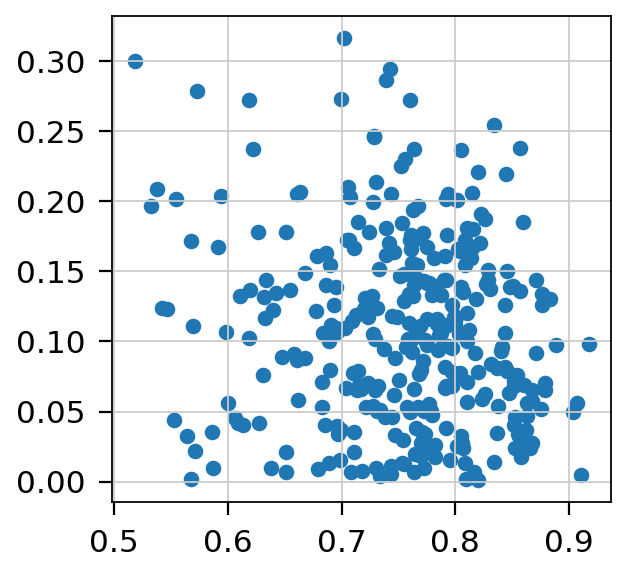

In [57]:
plt.scatter(abs(gene_pd['cor']),abs(gene_pd['Diagnosis_AD_cor']))

In [45]:
gene_pd.sort_values('cor')

cor
name               
AGAP2     -0.859962
LRRC73    -0.848590
CDK5      -0.841677
KLC2      -0.834097
PPFIA3    -0.832020
...             ...
LINC02607 -0.513809
PPP1R1A   -0.509887
FILIP1L   -0.477115
MYH7      -0.475316
SPHKAP    -0.437065

[293 rows x 1 columns]

In [41]:
module.loc[module['module']==5]

ivl  module     name    color
name                                   
CHGB      308       5     CHGB  #78C2ED
RASGRF1  3236       5  RASGRF1  #78C2ED
PCP4      953       5     PCP4  #78C2ED
CLGN     1304       5     CLGN  #78C2ED
CNTN6    1636       5    CNTN6  #78C2ED
...       ...     ...      ...      ...
PIN1     3314       5     PIN1  #78C2ED
NUDT4B   1185       5   NUDT4B  #78C2ED
NUDT4P2  1186       5  NUDT4P2  #78C2ED
NEFM      425       5     NEFM  #78C2ED
DBN1     3472       5     DBN1  #78C2ED

[293 rows x 4 columns]

In [33]:
bulk_adata.obs.columns

Index(['Unnamed: 0', 'RNAIsolation.Group', 'Dissection.Group', 'Sample.ID',
       'Case.Year', 'Case.Num', 'Region', 'Neuropath.Dx.1', 'Neuropath.Dx.2',
       'Age', 'Sex', 'PMI', 'APoE', 'Clinical.Syndrome', 'Tangle.Stage',
       'Plaque.Stage', 'Diagnosis', 'Plaques.Tangles', 'Braak...Braak.Stage',
       'Dissection.By', 'RNA.Isolation.By', 'RIN', 'Library.Group',
       'Sequencing.Group', 'TOTAL_READS', 'PF_READS', 'PF_READS_ALIGNED',
       'PCT_PF_READS_ALIGNED', 'PF_ALIGNED_BASES', 'PF_HQ_ALIGNED_READS',
       'PF_HQ_ALIGNED_BASES', 'PF_HQ_ALIGNED_Q20_BASES', 'PF_MISMATCH_RATE',
       'PF_HQ_ERROR_RATE', 'PF_INDEL_RATE', 'READS_ALIGNED_IN_PAIRS',
       'STRAND_BALANCE', 'PCT_CHIMERAS', 'PCT_ADAPTER',
       'UNPAIRED_READS_EXAMINED', 'UNMAPPED_READS', 'READ_PAIR_DUPLICATES',
       'READ_PAIR_OPTICAL_DUPLICATES', 'PERCENT_DUPLICATION',
       'ESTIMATED_LIBRARY_SIZE', 'PF_BASES', 'PF_ALIGNED_BASES.1',
       'RIBOSOMAL_BASES', 'CODING_BASES', 'UTR_BASES', 'INTRONIC_BASES'

In [16]:
meta=bulk_adata.obs[['Neuropath.Dx.1','APoE','Clinical.Syndrome',
                'Plaque.Stage','Tangle.Stage','Diagnosis']]

In [17]:
meta.head()

Neuropath.Dx.1 APoE Clinical.Syndrome Plaque.Stage  \
Sample-1            Alzheimer's disease  NaN               NaN      Stage B   
Sample-10           Alzheimer's disease  e43               NaN      Stage C   
Sample-100  Normal (Mild Braak Changes)  NaN               NaN      Stage B   
Sample-101  Normal (Mild Braak Changes)  NaN               NaN      Stage B   
Sample-11           Alzheimer's disease  e43               NaN      Stage C   

           Tangle.Stage Diagnosis  
Sample-1        Stage 5        AD  
Sample-10       Stage 6        AD  
Sample-100      Stage 2   Control  
Sample-101      Stage 2   Control  
Sample-11       Stage 5        AD

In [ ]:
from scipy.stats import spearmanr,pearsonr,kendalltau
pearsonr(pcamol.iloc[0],meta['Neuropath.Dx.1'])

In [76]:
one_hot = pd.get_dummies(meta['Neuropath.Dx.1'], prefix='Neuropath.Dx.1')
correlation = pd.concat([one_hot, pcamol.T], axis=1).corr()
print("Correlation:")
#print(correlation)

Correlation:


In [77]:
one_hot.iloc[:,0]

Sample-1      1
Sample-10     1
Sample-100    0
Sample-101    0
Sample-11     1
             ..
Sample-94     0
Sample-95     0
Sample-97     0
Sample-98     0
Sample-99     0
Name: Neuropath.Dx.1_Alzheimer's disease, Length: 90, dtype: uint8

In [78]:
correlation.loc[pcamol.index,one_hot.columns]

Neuropath.Dx.1_Alzheimer's disease  \
1                            -0.090956   
2                             0.011386   
3                            -0.050276   
4                            -0.016453   
5                             0.048773   
6                             0.120229   
7                             0.024379   
8                             0.057223   
9                             0.056288   
10                            0.083720   
11                           -0.038839   
12                            0.035151   
13                            0.020052   
14                            0.050601   
15                            0.036581   
16                            0.083759   
17                            0.074206   
18                            0.124334   
19                            0.068737   
20                            0.046723   

    Neuropath.Dx.1_Normal (Mild Braak Changes)  \
1                                    -0.045504   
2                                    -0.146219   
3                                    -0.043322   
4                                    -0.060074   
5                                    -0.094034   
6                                    -0.188830   
7                                    -0.121256   
8                                    -0.124502   
9                                    -0.144426   
10                                   -0.150719   
11                                   -0.027057   
12                                   -0.088667   
13                                   -0.095250   
14                                   -0.070532   
15                                   -0.135598   
16                                   -0.134144   
17                                   -0.111199   
18                                   -0.177901   
19                                   -0.115284   
20                                   -0.102561   

    Neuropath.Dx.1_Normal (Mild Vascular Changes)  \
1                                        0.076153   
2                                        0.055745   
3                                        0.037430   
4                                        0.033294   
5                                       -0.028231   
6                                       -0.008616   
7                                        0.051113   
8                                       -0.023578   
9                                        0.027866   
10                                       0.024895   
11                                      -0.051909   
12                                       0.023042   
13                                       0.026841   
14                                      -0.031979   
15                                       0.040344   
16                                      -0.013096   
17                                      -0.020763   
18                                      -0.012781   
19                                       0.010009   
20                                      -0.031038   

    Neuropath.Dx.1_Normal - No Pathology Detected  
1                                        0.182142  
2                                        0.188739  
3                                        0.135011  
4                                        0.107135  
5                                        0.094975  
6                                        0.116755  
7                                        0.126743  
8                                        0.128667  
9                                        0.127003  
10                                       0.091690  
11                                       0.151906  
12                                       0.072629  
13                                       0.107615  
14                                       0.054439  
15                                       0.137541  
16                                       0.090895  
17                                       0.074136  
18                  

In [68]:
import scipy.stats as stats
cross_tab = pd.crosstab(meta['Diagnosis'],pcamol.iloc[19])
cramer_v, p_value, _, _ = stats.chi2_contingency(cross_tab)
print("Cramer's V:")
print(cramer_v)

Cramer's V:
89.99999999999999


In [79]:
for i in range(len(pcamol)):   
    print(pearsonr(one_hot.iloc[:,0],pcamol.iloc[i]))

(-0.09095587685029954, 0.39388638430865186)
(0.011386158783763723, 0.9151760653023905)
(-0.05027625897231046, 0.637931363877025)
(-0.016452608654544513, 0.8776793238663136)
(0.04877333349941982, 0.6480244173040595)
(0.120229341478319, 0.2590024774573109)
(0.024378954311098253, 0.8195840288436709)
(0.05722331048498177, 0.5921528970840201)
(0.05628783007072482, 0.5982304607580752)
(0.08371976516523537, 0.43273981401746253)
(-0.03883850556805374, 0.7162753551205914)
(0.03515088321153045, 0.7422230948631503)
(0.02005150917265183, 0.8512019073864407)
(0.05060054843439705, 0.6357621076372053)
(0.03658072614742097, 0.7321260241274201)
(0.08375878319094886, 0.4325246349963188)
(0.07420596369387168, 0.48699373496144)
(0.12433390722744987, 0.24297463703083555)
(0.06873726360737169, 0.5197403868472898)
(0.04672303076485041, 0.6618963049003539)


In [91]:
bulk_adata.obs['Seq.PC3'].dtype

dtype('float64')

In [82]:
meta['Diagnosis'].dtype

CategoricalDtype(categories=['AD', 'Control'], ordered=False)

In [99]:
del meta['test']

In [50]:
new_meta=pd.DataFrame()
new_meta.index=meta.index
for j in meta.columns:
    if meta[j].dtype!='int64' and meta[j].dtype!='float32' and meta[j].dtype!='float64':
        one_hot = pd.get_dummies(meta[j], prefix=j)
        new_meta=pd.concat([new_meta,one_hot],axis=1)
    else:
        new_meta=pd.concat([new_meta,meta[j]],axis=1)
new_meta

Neuropath.Dx.1_Alzheimer's disease  \
Sample-1                                     1   
Sample-10                                    1   
Sample-100                                   0   
Sample-101                                   0   
Sample-11                                    1   
...                                        ...   
Sample-94                                    0   
Sample-95                                    0   
Sample-97                                    0   
Sample-98                                    0   
Sample-99                                    0   

            Neuropath.Dx.1_Normal (Mild Braak Changes)  \
Sample-1                                             0   
Sample-10                                            0   
Sample-100                                           1   
Sample-101                                           1   
Sample-11                                            0   
...                                                ...   
Sample-94                                            0   
Sample-95                                            0   
Sample-97                                            0   
Sample-98                                            1   
Sample-99                                            0   

            Neuropath.Dx.1_Normal (Mild Vascular Changes)  \
Sample-1                                                0   
Sample-10                                               0   
Sample-100                                              0   
Sample-101                                              0   
Sample-11                                               0   
...                                                   ...   
Sample-94                                               1   
Sample-95                                               0   
Sample-97                                               0   
Sample-98                                               0   
Sample-99                                               0   

            Neuropath.Dx.1_Normal - No Pathology Detected  APoE_e32  APoE_e33  \
Sample-1                                                0         0         0   
Sample-10                                               0         0         0   
Sample-100                                              0         0         0   
Sample-101                                              0         0         0   
Sample-11                                               0         0         0   
...                                                   ...       ...       ...   
Sample-94                                               0         0         0   
Sample-95                                               1         0         0   
Sample-97                                               1         0         0   
Sample-98                                               0         0         0   
Sample-99                                               1         0         0   

            APoE_e42  APoE_e43  APoE_e44  Clinical.Syndrome_[Dem]  ...  \
Sample-1           0         0         0                        0  ...   
Sample-10          0         1         0                        0  ...   
Sample-100         0         0         0                        0  ...   
Sample-101         0         0         0                        0  ...   
Sample-11          0         1         0                        0  ...   
...              ...       ...       ...                      ...  ...   
Sample-94          0         0         0                        0  ...   
Sample-95          0         0         0                        0  ...   
Sample-97          0         0         0                        0  ...   
Sample-98          0         0         0                        0  ...   
Sample-99          0         0         0                        0  ...   

            Plaque.Stage_Stage B  Plaque.Stage_Stage C  Tangle.Stage_Stage 1  \
Sample-1                       1       

In [19]:
print("...co-analysis have being done")
from scipy.stats import spearmanr,pearsonr,kendalltau
# seed random number generator
# calculate spearman's correlation
new_meta=pd.DataFrame()
new_meta.index=meta.index
for j in meta.columns:
    if meta[j].dtype!='int64' and meta[j].dtype!='float32' and meta[j].dtype!='float64':
        one_hot = pd.get_dummies(meta[j], prefix=j)
        new_meta=pd.concat([new_meta,one_hot],axis=1)
    else:
        new_meta=pd.concat([new_meta,meta[j]],axis=1)
new_meta


result_1=pd.DataFrame(columns=new_meta.columns)
result_p=pd.DataFrame(columns=new_meta.columns)
for j in new_meta.columns:
    co=[]
    pvv=[]
    for i in range(len(pcamol)):   
        tempcor=pd.DataFrame(columns=['x','y'])
        tempcor['x']=list(new_meta[j])
        tempcor['y']=list(pcamol.iloc[i])
        tempcor=tempcor.dropna()
        coef,pv=pearsonr(tempcor['x'],tempcor['y'])
        co.append(coef)
        pvv.append(pv)
    result_1[j]=co
    result_p[j]=pvv
        #print(coef)
result_1=abs(result_1)
result_1.index=set_index

...co-analysis have being done


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


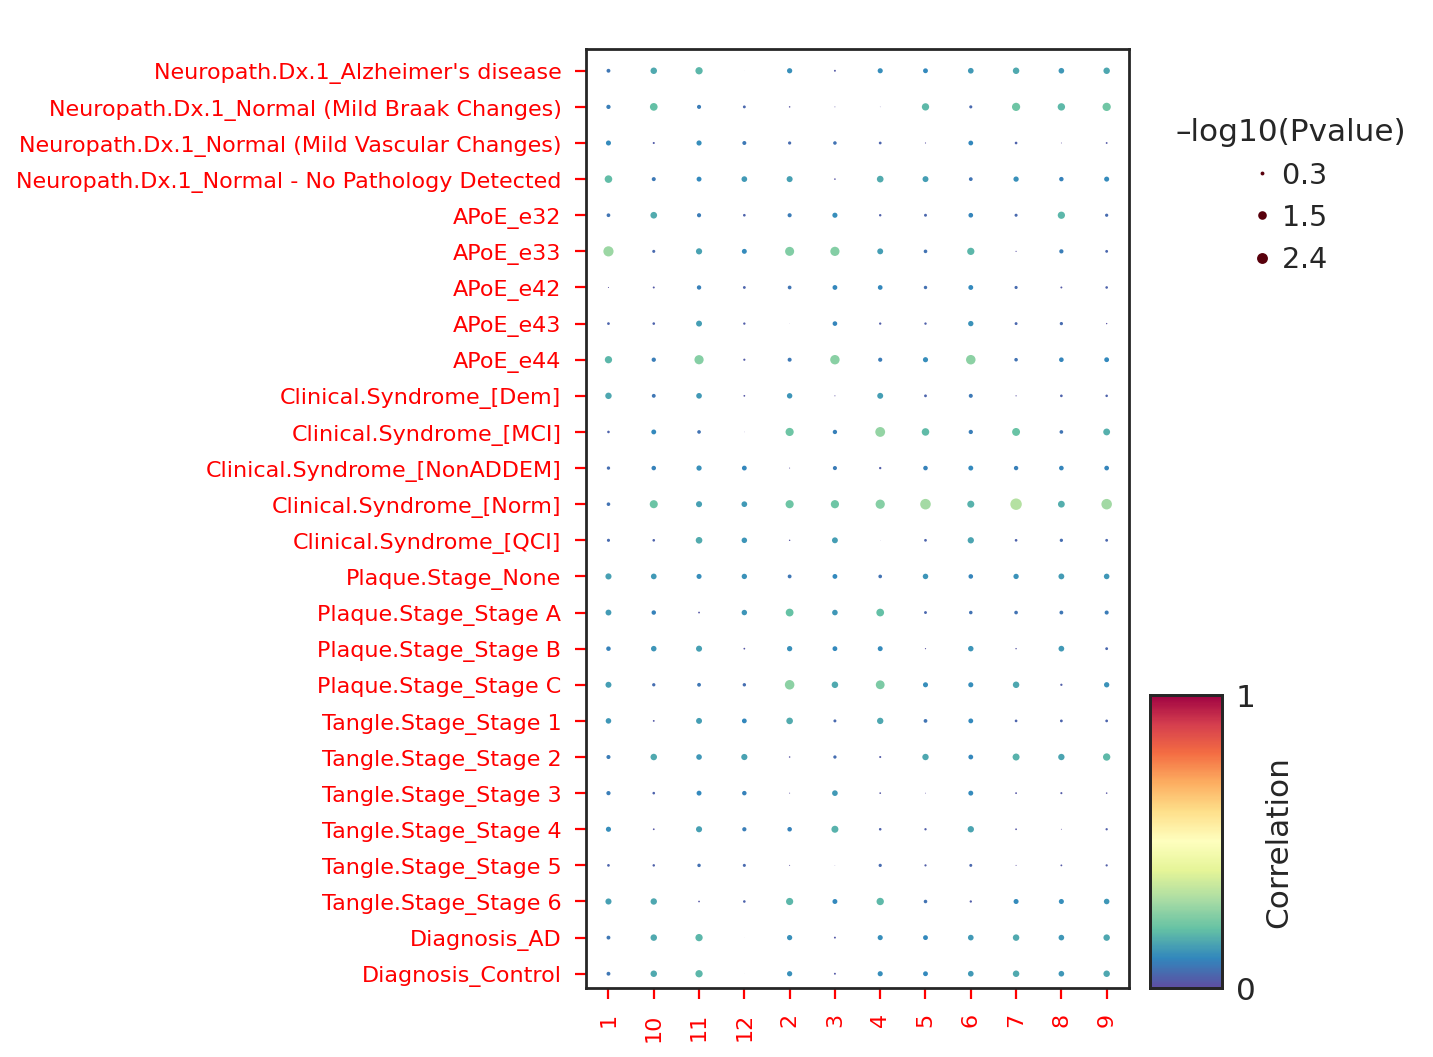

In [20]:
ax=gene_wgcna.plot_meta_correlation((result_1,result_p))

In [106]:
module['module'].value_counts()

1     1438
2      594
3      409
4      399
5      270
6      211
7      187
8      185
9      171
10     163
11     159
12     123
13     117
14     104
15      98
16      93
17      77
18      75
19      69
20      58
Name: module, dtype: int64

In [17]:
deg_result=pd.read_csv('deg_res.csv',index_col=0)
deg_result=deg_result.loc[deg_result['sig']!='normal']
deg_result.shape

(56, 11)

In [107]:
Type_color_dict={"Alzheimer's disease":'#F08888',"Normal - No Pathology Detected":'#CFDEFE'}
meta_color=pd.DataFrame(index=bulk_adata1.obs.index.tolist())
meta_color['Neuropath.Dx.1']=bulk_adata1.obs['Neuropath.Dx.1'].map(Type_color_dict)
meta_color.head()

Neuropath.Dx.1
Sample-1         #F08888
Sample-10        #F08888
Sample-11        #F08888
Sample-12        #F08888
Sample-13        #F08888

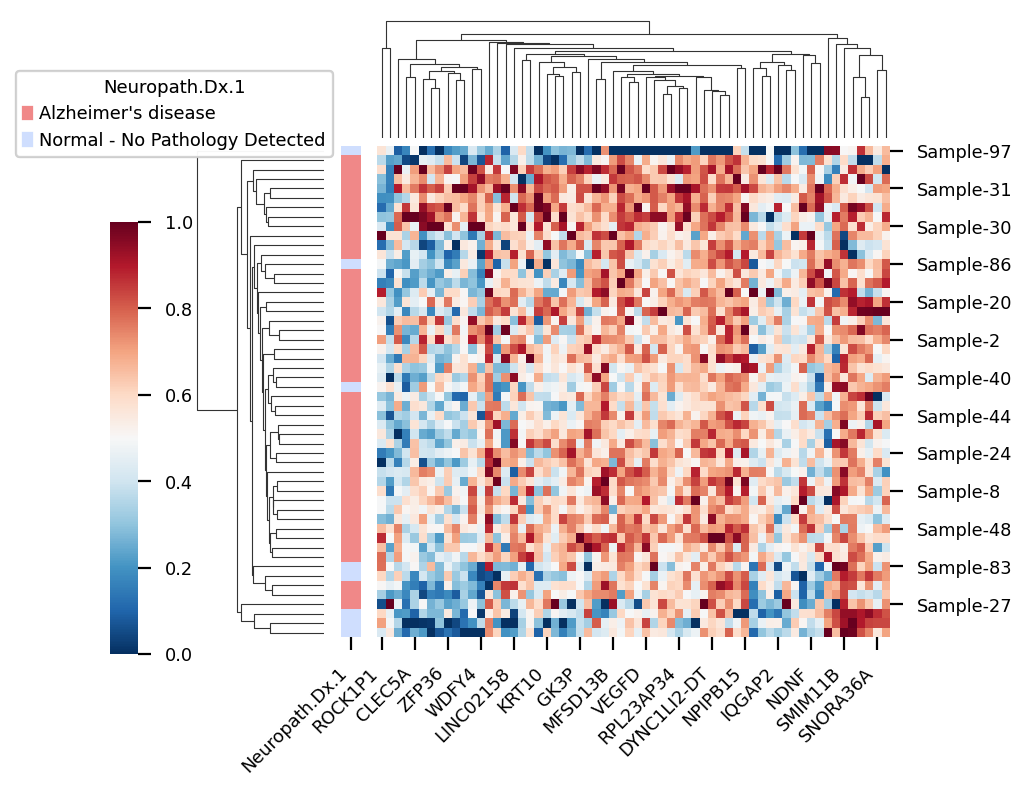

In [147]:
import seaborn as sns
ax=sns.clustermap(bulk_adata1[:,deg_result.index].to_df(),
              standard_scale = 1,cmap='RdBu_r',
                  figsize=(6,6),
               row_colors=meta_color,
              )
#设置聚类热图的横坐标标签大小跟角度
xticks=ax.ax_heatmap.xaxis.get_ticklabels()
plt.setp(xticks, rotation=45, horizontalalignment='right',fontsize=8)
#设置聚类热图的纵坐标标签大小
yticks=ax.ax_heatmap.yaxis.get_ticklabels()
plt.setp(yticks, rotation=0, horizontalalignment='left',fontsize=8)
#设置聚类类别方块，也就是Type跟Sample的字体大小跟角度
labels=ax.ax_row_colors.xaxis.get_ticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right',fontsize=8)
#去除横标签
ax.ax_heatmap.set_xlabel('')
#设置legend的位置
ax.cax.set_position([-.05, .3, .03, .45])
#设置legend的字体大小及其他属性
labels=ax.cax.get_yticklabels()
plt.setp(labels, rotation=0, horizontalalignment='left',fontsize=8)

ax_gca=plt.gca()
#绘制组别颜色条
for i,loc in zip(['Neuropath.Dx.1'],[2,3]):
    patches = [mpatches.Patch(color=Type_color_dict[label], label="{:s}".format(label)) for label in bulk_adata1.obs[i].unique()] 
    legend_ = plt.legend(handles=patches, fontsize=8,title_fontsize='xx-small',
                                  loc='center',title=i, ncol=1, bbox_to_anchor=(loc, 1, 0.5, 0.5), )
    ax_gca.add_artist(legend_)
plt.savefig("figures/deg_heatmap.png",dpi=300,bbox_inches = 'tight')
#ax.ax_row_dendrogram.legend(loc="best", ncol=1,bbox_to_anchor=(-.3, 0.7, 0.5, 0.5),fontsize=15)


In [124]:
bulk_adata1.obs.index.unique()

Index(['Sample-1', 'Sample-10', 'Sample-11', 'Sample-12', 'Sample-13',
       'Sample-14', 'Sample-16', 'Sample-17', 'Sample-19', 'Sample-2',
       'Sample-20', 'Sample-21', 'Sample-22', 'Sample-23', 'Sample-24',
       'Sample-25', 'Sample-26', 'Sample-27', 'Sample-28', 'Sample-3',
       'Sample-30', 'Sample-31', 'Sample-32', 'Sample-33', 'Sample-34',
       'Sample-35', 'Sample-36', 'Sample-37', 'Sample-38', 'Sample-4',
       'Sample-40', 'Sample-42', 'Sample-43', 'Sample-44', 'Sample-45',
       'Sample-46', 'Sample-47', 'Sample-48', 'Sample-49', 'Sample-5',
       'Sample-50', 'Sample-6', 'Sample-7', 'Sample-8', 'Sample-82',
       'Sample-83', 'Sample-85', 'Sample-86', 'Sample-88', 'Sample-95',
       'Sample-97', 'Sample-99'],
      dtype='object')

In [127]:
bulk_adata1.obs.loc['Sample-1','Neuropath.Dx.1']

"Alzheimer's disease"

In [23]:
gene_mad.sort_values(ascending=True).iloc[:5000]

symbol
UBR5       0.114665
MAP3K4     0.120879
ELOC       0.125466
PAXIP1     0.127256
USP24      0.129032
             ...   
SULT1A1    0.252600
IFT80      0.252640
HDAC3      0.252669
SZRD1      0.252670
DDX10      0.252674
Length: 5000, dtype: float64

## Different expression rate

In [ ]:
prop_pd=pd.DataFrame(index=module['module'].value_counts().index)
prop=[]
for i in module['module'].value_counts().index:
    t_module=module.loc[module['module']==i,'name'].tolist()
    ret_gene=list(set(deg_result.index) & set(t_module))
    prop.append(len(ret_gene)/len(t_module))
prop_pd['prop']=prop 
prop_pd

In [58]:
module.loc[module['name']=='MAPT']

Empty DataFrame
Columns: [ivl, module, name, color]
Index: []

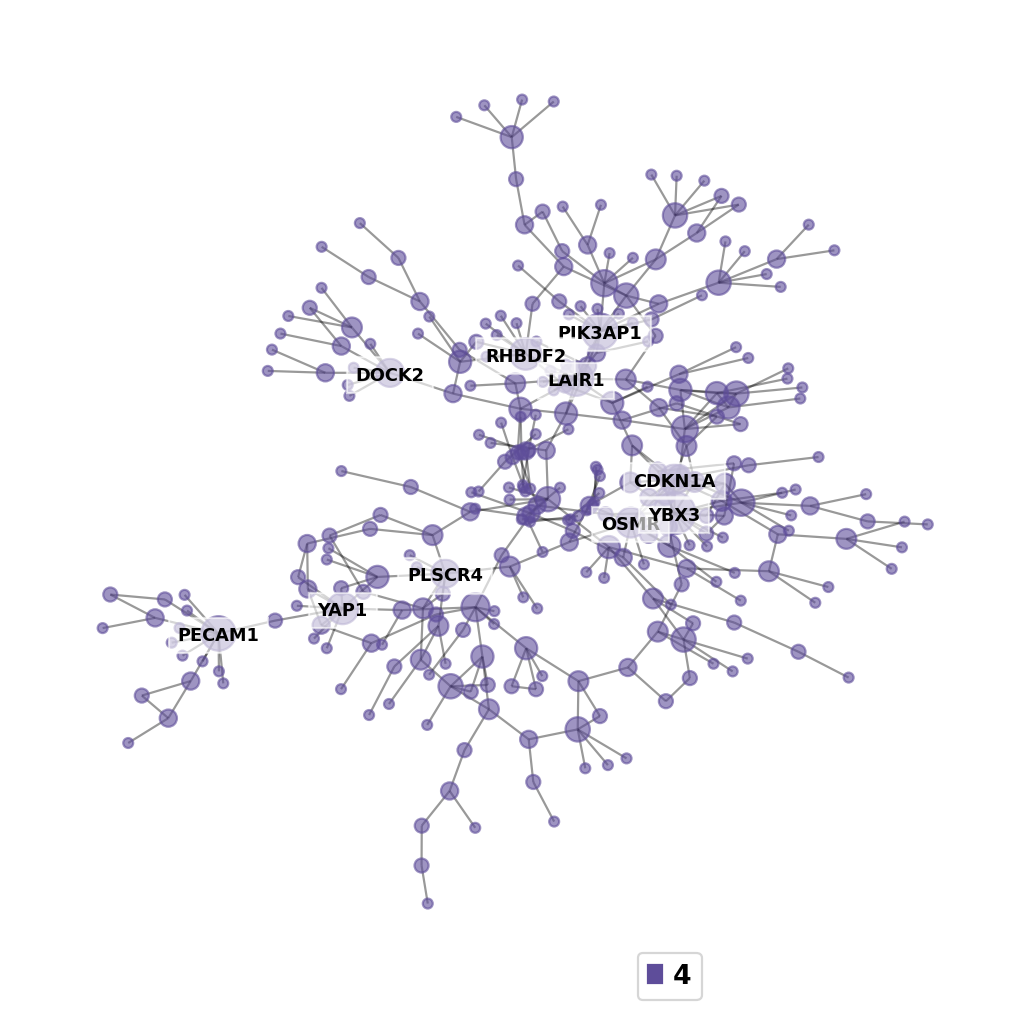

In [66]:
fig,ax=gene_wgcna.plot_sub_network([4],correlation_threshold=0.99,plot_gene_num=10,
                            pos_type='kamada_kawai',pos_scale=3,pos_dim=2,
                         figsize=(8,8),node_size=20,label_fontsize=8,
                        label_bbox={"ec": "white", "fc": "white", "alpha": 0.6})
fig.savefig("figures/wgcna_module_4.png",dpi=300,bbox_inches = 'tight')

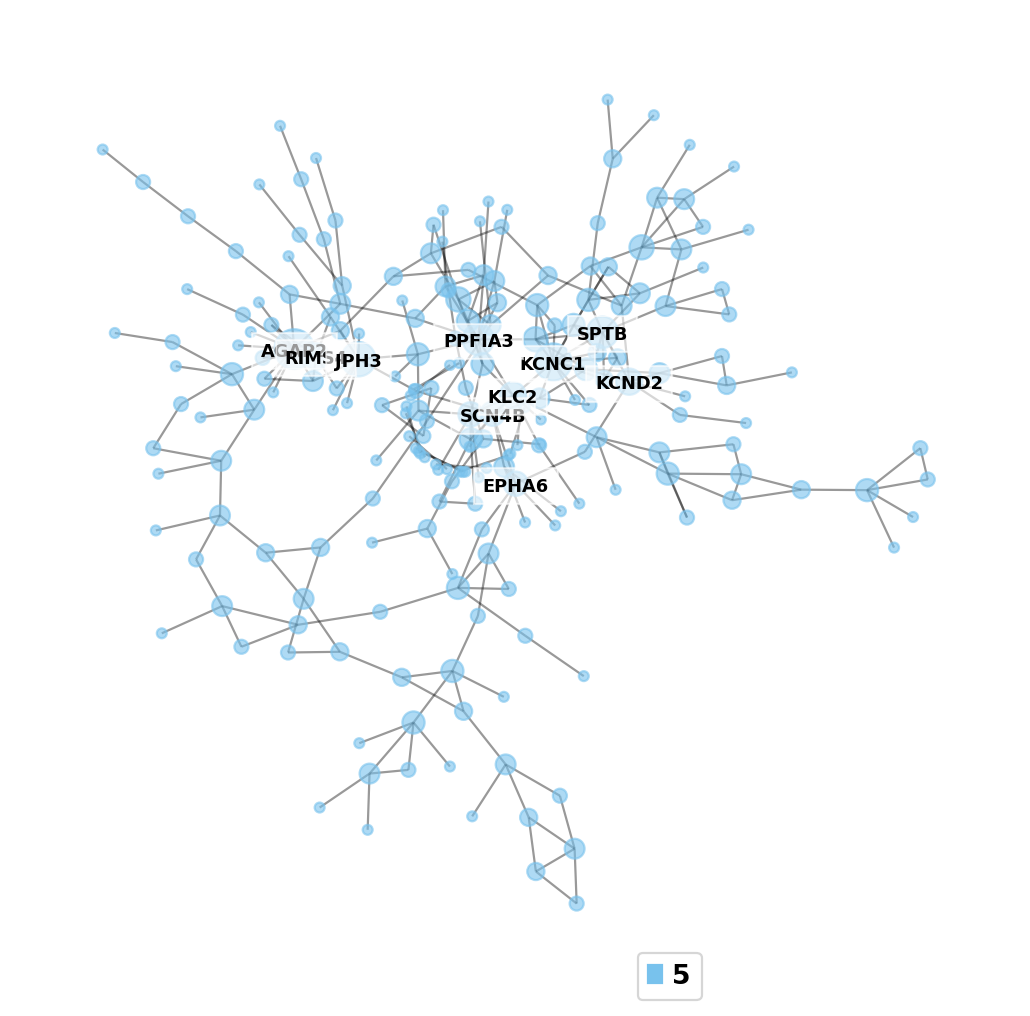

In [135]:
fig,ax=gene_wgcna.plot_sub_network([5],correlation_threshold=0.95,plot_gene_num=10,
                            pos_type='kamada_kawai',pos_scale=3,pos_dim=2,
                         figsize=(8,8),node_size=20,label_fontsize=8,
                        label_bbox={"ec": "white", "fc": "white", "alpha": 0.6})
fig.savefig("figures/wgcna_module_5.png",dpi=300,bbox_inches = 'tight')